<h1>3次元の変数にて因果推論</h1>
3次元、交互作用項なしで因果推論

In [488]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import optim
import pyro
import pyro.distributions as dist

from tensorboardX import SummaryWriter

from tqdm import tqdm
import time


import numpy as np
import random
from numpy.random import *
import matplotlib.pyplot as plt 
#np.random.seed(100)
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import csv

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

seed = 1234
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

In [489]:
size=70000
x1 = np.random.binomial(1,0.5,size=size)
x2 = np.random.normal(1.2*x1+0.5,0.6,size=size)
x3 = np.random.normal(-0.8*x1+0.2,0.3,size=size)
x4 = np.random.normal(0.2*x1+0.5,0.5,size=size)
effect = 1.5
beta2 = 0.8
beta3 = 0.3
beta4 = 0.5
eps = 1e-10
b = np.random.normal(3,0.2)


def kaiki(x1=x1,x2=x2,x3=x3,x4=x4,effect=effect,beta2=beta2,beta3=beta3, beta4=beta4,b=b):
    return effect*x1+beta2*x2+beta3*x3+beta4*x4+b

yogo = kaiki(x1,x2,x3,x4)
data = np.array((x1,x2,x3,x4,yogo)).T

In [490]:
train_data = np.array(data[:60000])#train[:,0]:conditional, train[:,1]:feature, train[:,2]:outcome
test_data  = np.array(data[60000:])

3.7552110161531607
6.078655194069614
2.3234441779164534


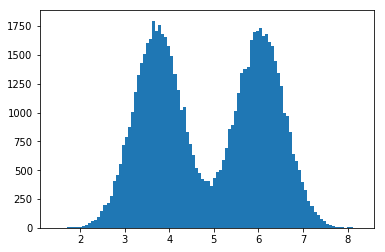

In [491]:
plt.hist(yogo, bins=100)
#x1=0のとき
x1 = 0
x2 = np.random.normal(1.2*x1+0.5,0.6,size=size)
x3 = np.random.normal(-0.8*x1+0.3,0.3,size=size)
x4 = np.random.normal(0.2*x1+0.5,0.5,size=size)
untreat_group = kaiki(x1=0,x2=x2,x3=x3,x4=x4,effect=effect,beta2=beta2,beta3=beta3, beta4=beta4,b=b)
print(untreat_group.mean())
#x1=1のとき
x1 = 1
x2 = np.random.normal(1.2*x1+0.5,0.6,size=size)
x3 = np.random.normal(-0.8*x1+0.3,0.3,size=size)
x4 = np.random.normal(0.2*x1+0.5,0.5,size=size)
treat_group = kaiki(x1=1,x2=x2,x3=x3,x4=x4,effect=effect,beta2=beta2,beta3=beta3, beta4=beta4,b=b)
print(treat_group.mean())
print(treat_group.mean()-untreat_group.mean())

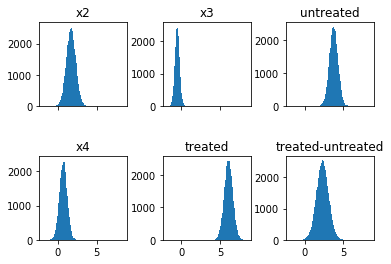

In [492]:
fig2, axes = plt.subplots(2, 3, sharex=True)
plt.subplots_adjust(wspace=0.4, hspace=0.6)
axes[0, 0].hist(x2, bins=100)
axes[0, 0].set_title('x2')
axes[0, 1].hist(x3, bins=100) 
axes[0, 1].set_title('x3')
axes[1, 0].hist(x4,bins=100) 
axes[1, 0].set_title('x4')
axes[1, 1].hist(treat_group, bins=100) 
axes[1, 1].set_title('treated')
axes[0, 2].hist(untreat_group,bins=100) 
axes[0, 2].set_title('untreated')
axes[1, 2].hist(treat_group-untreat_group, bins=100) 
axes[1, 2].set_title('treated-untreated')
plt.show()

In [493]:
size=70000
x1 = np.random.binomial(1,0.5,size=size)
x2 = np.random.normal(1.2*x1+0.5,0.6,size=size)
x3 = np.random.normal(-0.8*x1+0.2,0.3,size=size)
x4 = np.random.normal(0.2*x1+0.5,0.5,size=size)
effect = 1.5
beta2 = 0.8
beta3 = 0.3
beta4 = 0.5
eps = 1e-10
b = np.random.normal(3,0.2)


def kaiki(x1=x1,x2=x2,x3=x3,x4=x4,effect=effect,beta2=beta2,beta3=beta3, beta4=beta4,b=b):
    return effect*x1+beta2*x2+beta3*x3+beta4*x4+b

yogo = kaiki(x1,x2,x3,x4)
data = np.array((x1,x2,x3,x4,yogo)).T

train_data = np.array(data[:60000])#train[:,0]:conditional, train[:,1]:feature, train[:,2]:outcome
test_data  = np.array(data[60000:])

In [494]:
batch_size = 100
num_iters = 6000
num_epochs = int(batch_size* num_iters/len(train_data))

In [495]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [496]:
num_epochs

10

In [497]:
from pixyz.distributions import Bernoulli, Normal
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE

In [498]:
class Inference(Normal):
    def __init__(self, input_dim,cond_dim, hidden_dim, latent_dim):
        super(Inference, self).__init__(cond_var=["x","y"], var=["z"], name="q")
        
        self.fc1 = nn.Linear(input_dim+cond_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, latent_dim)
        self.fc32 = nn.Linear(hidden_dim, latent_dim)
    def forward(self,x,y):
        h = F.relu(self.fc1(torch.cat([x,y],1)))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

class Generator(Normal):
    def __init__(self, latent_dim,cond_dim, hidden_dim, output_dim):
        super(Generator, self).__init__(cond_var=["z","y"], var=["x"], name="p")
        
        self.fc1 = nn.Linear(latent_dim+cond_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, output_dim)
        self.fc32 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,z,y):
        h = F.relu(self.fc1(torch.cat([z,y],1)))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}


In [499]:
input_dim = len(data[0])-2
hidden_dim = 100
latent_dim = 3
output_dim = input_dim
cond_dim = 2
estimate_dim =1

In [500]:
p = Generator(latent_dim,cond_dim, hidden_dim, output_dim)
q = Inference(input_dim,cond_dim, hidden_dim, latent_dim)


p.to(device)
q.to(device)


Inference(
  (fc1): Linear(in_features=5, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc31): Linear(in_features=100, out_features=3, bias=True)
  (fc32): Linear(in_features=100, out_features=3, bias=True)
)

In [501]:
loc = torch.tensor(0.)
scale = torch.tensor(1.)
prior = Normal(loc=loc, scale=scale, var=["z"], dim= latent_dim, name="p_prior")

In [502]:
kl = KullbackLeibler(q,prior)


In [503]:
model = VAE(q,p, regularizer = kl, optimizer=optim.Adam, optimizer_params={"lr":1e-3})

In [504]:
print(data[:,0]) #xtreat
print(data[:,1]) #x2
print(data[:,2]) #x3
print(data[:,3]) #x4
print(data[:,4]) #yogo
len(data[0])

[0. 1. 1. ... 1. 1. 1.]
[0.87832723 2.0168811  1.36844203 ... 1.64282224 2.15176199 1.86661387]
[ 0.44339339 -0.02996228 -0.54143963 ... -0.42253145 -0.20153959
 -0.45568241]
[ 0.1580671   1.25182669 -0.0632113  ...  0.8714384   0.66811251
  0.94845277]
[4.11246729 6.92818348 5.59847002 ... 6.3209715  6.69275791 6.52856669]


5

In [505]:
def input_shaper(x,input_dim):
    return x.view(-1, input_dim).float()
    
def tag_shaper(tag):
    return torch.eye(2)[tag.long()].float()

"""
def data_shaper(x,y, input_dim):
    x = x.view(-1, input_dim).float()
    y = torch.eye(2)[y.long()].float()
    return x,y
"""

def train(epoch, input_dim):
    train_loss = 0
    for _data in tqdm(train_loader):
        y = tag_shaper(_data[:,0])
        x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        x = x.to(device)
        y = y.to(device)
       
        loss = model.train({"x":x, "y":y})
        train_loss += loss
    #pytorchのlossはデフォルトでは平均の値になる。このためバッチ長をかけて
    #全体で割って全体のlossを計算する
    
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('Epoch:{} Train loss:{:.4f}'.format(epoch, train_loss))
    return train_loss

In [506]:
def test(epoch, input_dim):
    test_loss = 0
    for _data in test_loader:
        y = tag_shaper(_data[:,0])
        x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        x = x.to(device)
        y = y.to(device)
        
        loss = model.test({"x":x, "y":y})
        test_loss += loss
    test_loss = test_loss * test_loader.batch_size/ len(test_loader.dataset)
    print('Test loss:{:.4f}'.format(test_loss))
    return test_loss

In [507]:
def plot_reconstrunction(x,y,output_dim):
    with torch.no_grad():
        z = q.sample({"x":x, "y":y}, return_all=False)
        z.update({"y":y})
        recon_batch = p.sample_mean(z).view(-1, output_dim)
        recon = torch.cat([x.view(-1, output_dim), recon_batch]).cpu()
        return recon

def plot_image_from_latent(z,y, output_dim):
    with torch.no_grad():
        sample = p.sample_mean({"z":z, "y":y}).view(-1, output_dim).cpu()
        return sample

def plot_reconstraction_changing_y(x,y, output_dim):
    y_change = torch.eye(2)[range(2)].to(device)
    batch_dummy = torch.ones(x.size(0))[:, None].to(device)
    recon_all = []
    
    with torch.no_grad():
        for _y in y_change:
            z = q.sample({"x": x, "y": y}, return_all=False)   #batch数だけx,yを代入
            z.update({"y": batch_dummy * _y[None,:]})
            
            recon_batch = p.sample_mean(z).view(-1, output_dim)
            recon_all.append(recon_batch)
            
        recon_changing_y = torch.cat(recon_all)
        recon_changing_y = torch.cat([x.view( -1, output_dim), recon_changing_y]).cpu()
        
        return recon_changing_y

In [508]:
writer = SummaryWriter()

plot_number = 1

z_sample = 0.5 * torch.randn(64, latent_dim).to(device)
y_sample = torch.eye(2)[[plot_number]*64].to(device)

_data = iter(test_loader).next()

_y = tag_shaper(_data[:,0])
_x = input_shaper(_data[:, 1:input_dim+1],input_dim)
_x = _x.to(device)
_y = _y.to(device)

for epoch in range(1, num_epochs + 1):
    train_loss = train(epoch, input_dim)
    test_loss = test(epoch, input_dim)
    
    recon = plot_reconstrunction(_x[:8], _y[:8], output_dim)
    sample = plot_image_from_latent(z_sample, y_sample, output_dim)
    recon_changing_y = plot_reconstraction_changing_y(_x[:8], _y[:8], output_dim)
    

    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)      
    """
    writer.add_image('Image_from_latent', sample, epoch)
    writer.add_image('Image_reconstrunction', recon, epoch)
    writer.add_image('Image_reconstrunction_change_y', recon_changing_y, epoch)
    """
writer.close()

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:1 Train loss:1.9162
Test loss:1.8368


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:2 Train loss:1.8561
Test loss:1.8396


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:3 Train loss:1.8551
Test loss:1.8358


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:4 Train loss:1.8504
Test loss:1.8376


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:5 Train loss:1.8520
Test loss:1.8494


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:6 Train loss:1.8521
Test loss:1.8389


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:7 Train loss:1.8501
Test loss:1.8460


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:8 Train loss:1.8501
Test loss:1.8343


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:9 Train loss:1.8492
Test loss:1.8405


100%|██████████| 600/600 [00:03<00:00, 175.73it/s]


Epoch:10 Train loss:1.8488
Test loss:1.8361


In [509]:
_data= iter(train_loader).next()
_data = _data[:8]
y = tag_shaper(_data[:,0])
x = input_shaper(_data[:, 1:input_dim+1],input_dim)

x = x.to(device)
y = y.to(device)


print(np.hstack(( x.cpu(),y.cpu() ) ))
#print(x)
#print((x,y))
test = plot_reconstraction_changing_y(x,y, output_dim).cpu()
#print(test.reshape(8,-1))

[[ 0.2481877   0.43345177  0.98622704  1.          0.        ]
 [ 0.91855085  0.07884631  0.41156712  1.          0.        ]
 [ 0.46802333  0.1963484   0.16660094  1.          0.        ]
 [-0.56149286  0.55212474  1.1318889   1.          0.        ]
 [ 1.5101316   0.50362766  0.9352618   1.          0.        ]
 [ 0.00343646 -0.03561121  0.61474615  1.          0.        ]
 [ 1.3599315  -0.5797519   0.07884403  0.          1.        ]
 [ 0.10347268 -0.11793464 -0.38974667  1.          0.        ]]


In [510]:
re_test=test.reshape(-1,8,3)
#print(test.reshape(-1,8,3))
print(re_test[1,:,:].cpu())
print(re_test[2,:,:].cpu())

tensor([[0.4515, 0.1826, 0.5177],
        [0.4467, 0.1844, 0.5740],
        [0.4205, 0.1954, 0.5133],
        [0.4443, 0.1806, 0.5173],
        [0.4580, 0.2103, 0.5347],
        [0.4885, 0.1763, 0.5160],
        [0.4492, 0.1874, 0.5226],
        [0.4535, 0.1929, 0.5264]])
tensor([[ 1.6328, -0.6238,  0.6794],
        [ 1.6547, -0.6143,  0.6902],
        [ 1.6106, -0.6173,  0.6770],
        [ 1.6643, -0.6272,  0.6821],
        [ 1.6499, -0.5973,  0.6898],
        [ 1.6663, -0.6297,  0.6919],
        [ 1.6749, -0.6423,  0.6874],
        [ 1.6242, -0.6229,  0.7002]])


In [511]:
###以下やり直し
making_pt_size =1
pt_maker = torch.utils.data.DataLoader(dataset=train_data, batch_size = making_pt_size, shuffle=True)
for _data in pt_maker:
    y = tag_shaper(_data[:,0])
    x = input_shaper(_data[:, 1:input_dim+1],input_dim)

    x = x.to(device)
    y = y.to(device)
    gen_pt = plot_reconstraction_changing_y(x,y, output_dim).cpu().reshape(3,input_dim,-1)


In [512]:
"""
print(gen_pt)
print(gen_pt[0]) #元の患者
print(gen_pt[1]) # y=0
print(gen_pt[2] )#y=1
print(gen_pt[1,0]) #y=0の患者の1番目の変数
print(gen_pt[1,1]) #y=0の患者の2番目の変数
print(gen_pt[1,2]) #y=0の患者の3番目の変数
"""

'\nprint(gen_pt)\nprint(gen_pt[0]) #元の患者\nprint(gen_pt[1]) # y=0\nprint(gen_pt[2] )#y=1\nprint(gen_pt[1,0]) #y=0の患者の1番目の変数\nprint(gen_pt[1,1]) #y=0の患者の2番目の変数\nprint(gen_pt[1,2]) #y=0の患者の3番目の変数\n'

In [513]:
making_pt_size =10000
pt_maker = torch.utils.data.DataLoader(dataset=train_data, batch_size = making_pt_size, shuffle=True)
for _data in pt_maker:
    y = tag_shaper(_data[:,0])
    x = input_shaper(_data[:, 1:input_dim+1],input_dim)

    x = x.to(device)
    y = y.to(device)
    #gen_pt[i,j,:] #y=i-1の患者のj+1番目の変数
    #gen_pt = plot_reconstraction_changing_y(x,y, output_dim).cpu().reshape(3,input_dim,-1)　
    gen_pt = plot_reconstraction_changing_y(x,y, output_dim).cpu().reshape(3,input_dim,-1)

In [514]:
#x2 = np.random.normal(1.2*x1+0.5,0.6,size=size)
#x3 = np.random.normal(-0.8*x1+0.2,0.3,size=size)
#x4 = np.random.normal(0.2*x1+0.5,0.5,size=size)

"""
#x1=0のとき
x1 = 0
x2 = np.random.normal(1.2*x1+0.5,0.6,size=size)
x3 = np.random.normal(-0.8*x1+0.3,0.3,size=size)
x4 = np.random.normal(0.2*x1+0.5,0.5,size=size)
untreat_group = kaiki(x1=0,x2=x2,x3=x3,x4=x4,effect=effect,beta2=beta2,beta3=beta3, beta4=beta4,b=b)
print(untreat_group.mean())
#x1=1のとき
x1 = 1
x2 = np.random.normal(1.2*x1+0.5,0.6,size=size)
x3 = np.random.normal(-0.8*x1+0.3,0.3,size=size)
x4 = np.random.normal(0.2*x1+0.5,0.5,size=size)
treat_group = kaiki(x1=1,x2=x2,x3=x3,x4=x4,effect=effect,beta2=beta2,beta3=beta3, beta4=beta4,b=b)
print(treat_group.mean())
print(treat_group.mean()-untreat_group.mean())
"""
#gen_pt[1,0,:] #y=0の患者の1番目の変数
#gen_pt[1,1,:] #y=0の患者の2番目の変数
#gen_pt[1,2,:] #y=0の患者の3番目の変数
#gen_pt[2,0,:] #y=1の患者の1番目の変数
#gen_pt[2,1,:] #y=1の患者の2番目の変数
#gen_pt[2,2,:] #y=1の患者の3番目の変数

'\n#x1=0のとき\nx1 = 0\nx2 = np.random.normal(1.2*x1+0.5,0.6,size=size)\nx3 = np.random.normal(-0.8*x1+0.3,0.3,size=size)\nx4 = np.random.normal(0.2*x1+0.5,0.5,size=size)\nuntreat_group = kaiki(x1=0,x2=x2,x3=x3,x4=x4,effect=effect,beta2=beta2,beta3=beta3, beta4=beta4,b=b)\nprint(untreat_group.mean())\n#x1=1のとき\nx1 = 1\nx2 = np.random.normal(1.2*x1+0.5,0.6,size=size)\nx3 = np.random.normal(-0.8*x1+0.3,0.3,size=size)\nx4 = np.random.normal(0.2*x1+0.5,0.5,size=size)\ntreat_group = kaiki(x1=1,x2=x2,x3=x3,x4=x4,effect=effect,beta2=beta2,beta3=beta3, beta4=beta4,b=b)\nprint(treat_group.mean())\nprint(treat_group.mean()-untreat_group.mean())\n'

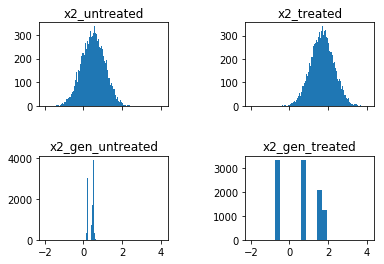

In [515]:
fig, axes = plt.subplots(2, 2, sharex=True)
plt.subplots_adjust(wspace=0.6, hspace=0.6)
axes[0,0].hist(np.random.normal(0.5,0.6,10000),bins=100)
axes[0,0].set_title('x2_untreated')
axes[0,1].hist(np.random.normal(1.7,0.6,10000),bins=100)
axes[0,1].set_title('x2_treated')
axes[1,0].hist(gen_pt[1,0,:])
axes[1,0].set_title('x2_gen_untreated')
axes[1,1].hist(gen_pt[2,0,:])
axes[1,1].set_title('x2_gen_treated')


"""
axes[0, 0].hist(gen_pt[1,:], bins=100)
axes[0, 0].set_title('generater1')
axes[0, 1].hist(gen_pt[2,:], bins=100) 
axes[0, 1].set_title('generater2')
axes[1, 0].hist(np.random.normal(0.5,0.2,10000),bins=100) 
axes[1, 0].set_title('original1')
axes[1, 1].hist(np.random.normal(0.9,0.2,10000), bins=100) 
axes[1, 1].set_title('original2')
"""
plt.show()

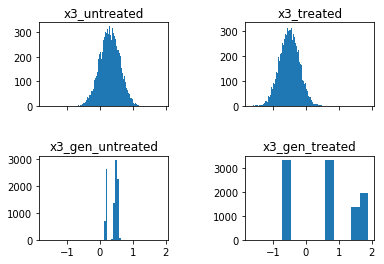

In [516]:
fig, axes = plt.subplots(2, 2, sharex=True)
plt.subplots_adjust(wspace=0.6, hspace=0.6)
axes[0,0].hist(np.random.normal(0.3,0.3,10000),bins=100)
axes[0,0].set_title('x3_untreated')
axes[0,1].hist(np.random.normal(-0.5,0.3,10000),bins=100)
axes[0,1].set_title('x3_treated')
axes[1,0].hist(gen_pt[1,1,:])
axes[1,0].set_title('x3_gen_untreated')
axes[1,1].hist(gen_pt[2,1,:])
axes[1,1].set_title('x3_gen_treated')
plt.show()

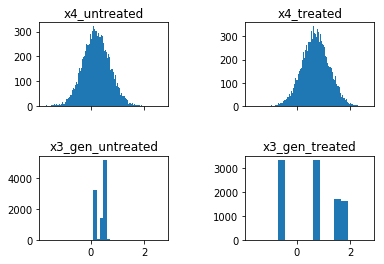

In [517]:
#x4 = np.random.normal(0.2*x1+0.5,0.5,size=size)
fig, axes = plt.subplots(2, 2, sharex=True)
plt.subplots_adjust(wspace=0.6, hspace=0.6)
axes[0,0].hist(np.random.normal(0.2,0.5,10000),bins=100)
axes[0,0].set_title('x4_untreated')
axes[0,1].hist(np.random.normal(0.7,0.5,10000),bins=100)
axes[0,1].set_title('x4_treated')
axes[1,0].hist(gen_pt[1,2,:],bins=5)
axes[1,0].set_title('x3_gen_untreated')
axes[1,1].hist(gen_pt[2,2,:])
axes[1,1].set_title('x3_gen_treated')
plt.show()

In [474]:
pt_size = 1000
z_sample = 3 * torch.randn(pt_size, latent_dim).to(device)

# 非治療群を生成
plot_number = 0
y_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
untreated =  plot_image_from_latent(z_sample,y_sample , output_dim)

# 治療群を生成
plot_number = 1
y_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
treated =  plot_image_from_latent(z_sample,y_sample , output_dim)


In [518]:
class Estimator(nn.Module):
    def __init__(self, cond_dim, hidden_dim, latent_dim, estimate_dim):
        super(Estimator, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim+cond_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, estimate_dim)
        
    def forward(self,z,y):
        h = F.relu(self.fc1(torch.cat([z,y],1)))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

criterion = nn.MSELoss()
model2 = Estimator(cond_dim, hidden_dim, latent_dim, estimate_dim)
model2.to(device)
optimizer = torch.optim.SGD(model2.parameters(),lr=1e-3)

In [520]:
for epoch in range(1, num_epochs+1):
    for _data in tqdm(train_loader):
        y = tag_shaper(_data[:,0])
        x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        o = input_shaper(_data[:, input_dim+1],estimate_dim)
        x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
        optimizer.zero_grad()
        
        z = q.sample({"x":x, "y":y}, return_all=False)
        latent = z.get('z')
        output = model2(latent,y)
        loss = criterion(output,o)        
        loss.backward()
        
        optimizer.step()
    
    total = 0
    total_loss = 0
    for _data in test_loader:
        y = tag_shaper(_data[:,0])
        x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        o = input_shaper(_data[:, input_dim+1],estimate_dim)
        x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
        z = q.sample({"x":x, "y":y}, return_all=False)
        latent = z.get('z')
        output = model2(latent,y)
        loss = criterion(output,o)
        
        total_loss += loss *len(_data)
        total += len(_data)
    test_loss = total_loss/total
    
    print('Epochs:{}, train_Loss:{}, test_Loss:{:.2f}'.format(epoch,loss.item(), test_loss.item()))
    

  8%|▊         | 47/600 [00:00<00:01, 468.47it/s]

Epochs:1, train_Loss:0.5325461626052856, test_Loss:0.46


  8%|▊         | 48/600 [00:00<00:01, 474.42it/s]

Epochs:2, train_Loss:0.3807487487792969, test_Loss:0.35


  8%|▊         | 50/600 [00:00<00:01, 492.53it/s]

Epochs:3, train_Loss:0.3615328073501587, test_Loss:0.32


  8%|▊         | 48/600 [00:00<00:01, 478.00it/s]

Epochs:4, train_Loss:0.3384358882904053, test_Loss:0.31


  8%|▊         | 48/600 [00:00<00:01, 471.91it/s]

Epochs:5, train_Loss:0.3453643023967743, test_Loss:0.30


  8%|▊         | 49/600 [00:00<00:01, 485.65it/s]

Epochs:6, train_Loss:0.3320479691028595, test_Loss:0.30


  8%|▊         | 48/600 [00:00<00:01, 476.26it/s]

Epochs:7, train_Loss:0.3293464779853821, test_Loss:0.30


  8%|▊         | 48/600 [00:00<00:01, 477.33it/s]

Epochs:8, train_Loss:0.3154674470424652, test_Loss:0.30


  8%|▊         | 49/600 [00:00<00:01, 486.80it/s]

Epochs:9, train_Loss:0.313138872385025, test_Loss:0.30


100%|██████████| 600/600 [00:01<00:00, 481.61it/s]


Epochs:10, train_Loss:0.32193633913993835, test_Loss:0.30


In [521]:
pt_size = 10000
z_sample = 1 * torch.randn(pt_size, latent_dim).to(device)

# 非治療群を生成
plot_number = 0
y_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
untreated =  plot_image_from_latent(z_sample,y_sample , output_dim)
untreated_outcome = model2(z_sample, y_sample)
# 治療群を生成
plot_number = 1
y_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
treated =  plot_image_from_latent(z_sample,y_sample , output_dim)
treated_outcome = model2(z_sample, y_sample)

3.9115386
6.2261705


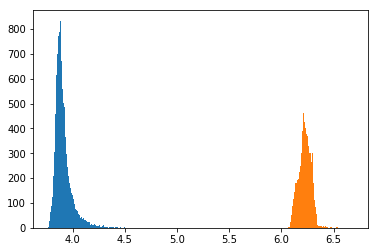

In [522]:
plt.hist(untreated_outcome.cpu().detach().numpy(),bins=100)
print(untreated_outcome.cpu().detach().numpy().mean())
plt.hist(treated_outcome.cpu().detach().numpy(), bins=100)
print(treated_outcome.cpu().detach().numpy().mean())

(array([  4.,   3.,  11.,  24.,  50.,  52.,  89., 115., 118., 146., 149.,
        180., 180., 179., 193., 197., 234., 225., 250., 256., 301., 341.,
        388., 462., 460., 428., 403., 420., 376., 370., 357., 329., 301.,
        305., 302., 262., 267., 303., 266., 181., 112., 122.,  85.,  55.,
         16.,  12.,   8.,  12.,   8.,   8.,   7.,   8.,  11.,   5.,   7.,
          4.,   2.,   6.,   2.,   4.,   4.,   3.,   1.,   2.,   0.,   3.,
          1.,   2.,   1.,   2.,   0.,   0.,   1.,   0.,   2.,   0.,   2.,
          0.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([6.0670304, 6.073192 , 6.0793543, 6.085516 , 6.091678 , 6.09784  ,
        6.1040015, 6.1101637, 6.1163254, 6.1224875, 6.128649 , 6.1348114,
        6.140973 , 6.147135 , 6.153297 , 6.1594586, 6.165621 , 6.1717825,
        6.177944 , 6.1841063, 6.190268 , 6.19643  , 6.202592 , 6.2087536,
        6.2149158, 6.2

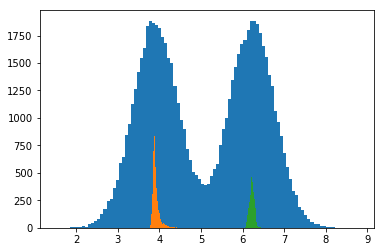

In [526]:
plt.hist(data[:,input_dim+1],bins=100)
plt.hist(untreated_outcome.cpu().detach().numpy(),bins=100)
plt.hist(treated_outcome.cpu().detach().numpy(),bins=100)

2.314632

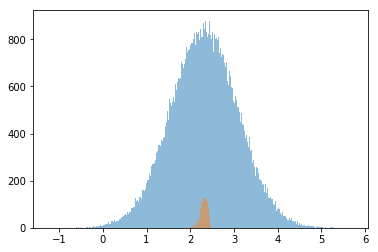

In [527]:
plt.hist(treat_group-untreat_group, bins=300, alpha=0.5)
plt.hist(treated_outcome.cpu().detach().numpy()-untreated_outcome.cpu().detach().numpy(),bins=300,alpha=0.5)
(treated_outcome.cpu().detach().numpy()-untreated_outcome.cpu().detach().numpy()).mean()

In [530]:
"""
size=70000
x1 = np.random.binomial(1,0.5,size=size)
x2 = np.random.normal(1.2*x1+0.5,0.6,size=size)
x3 = np.random.normal(-0.8*x1+0.2,0.3,size=size)
x4 = np.random.normal(0.2*x1+0.5,0.5,size=size)
effect = 1.5
beta2 = 0.8
beta3 = 0.3
beta4 = 0.5
eps = 1e-10
b = np.random.normal(3,0.2)


def kaiki(x1=x1,x2=x2,x3=x3,x4=x4,effect=effect,beta2=beta2,beta3=beta3, beta4=beta4,b=b):
    return effect*x1+beta2*x2+beta3*x3+beta4*x4+b

yogo = kaiki(x1,x2,x3,x4)
data = np.array((x1,x2,x3,x4,yogo)).T
"""

x1 = np.ones(70000)
x2 = np.random.normal(1.2*x1+0.5,0.6,size=size)
x3 = np.random.normal(-0.8*x1+0.2,0.3,size=size)
x4 = np.random.normal(0.2*x1+0.5,0.5,size=size)
t_yogo = kaiki(x1,x2,x3,x4)
t_data = np.array((x1,x2,x3,x4,yogo)).T


x1= np.zeros(70000)
xx2 = np.random.normal(1.2*x1+0.5,0.6,size=size)
x3 = np.random.normal(-0.8*x1+0.2,0.3,size=size)
x4 = np.random.normal(0.2*x1+0.5,0.5,size=size)
u_yogo = kaiki(x1,x2,x3,x4)
u_data = np.array((x1,x2,x3,x4,yogo)).T

In [551]:
t_pt_maker = torch.utils.data.DataLoader(dataset=t_data, batch_size = 30000, shuffle=True)
for _data in t_pt_maker:
    y = tag_shaper(_data[:,0])-1                                                     #治療群のラベルを非治療にする
    x = input_shaper(_data[:, 1:input_dim+1],input_dim)
    o = input_shaper(_data[:, input_dim+1],estimate_dim)
    x = x.to(device)
    y = y.to(device)
    o = o.to(device)
    with torch.no_grad():
        z1 = q.sample({"x": x, "y": y}, return_all=False)
        latent = z1.get('z')
        t_output=model2(latent,y)

4.0829515


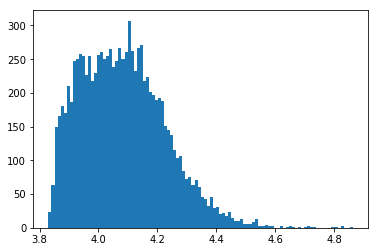

In [552]:
plt.hist(t_output.cpu().numpy(), bins=100)
output_mean=t_output.cpu().numpy().mean()
print(output_mean)

In [550]:
u_data

array([[0.        , 1.44651408, 0.12318239, 0.3747348 , 4.11246729],
       [0.        , 2.31630604, 0.16479603, 0.82076211, 6.92818348],
       [0.        , 1.42769416, 0.21770803, 0.87219696, 5.59847002],
       ...,
       [0.        , 2.02917604, 0.26254625, 0.94970842, 6.3209715 ],
       [0.        , 1.84566188, 0.29024823, 1.13348959, 6.69275791],
       [0.        , 1.56089393, 0.30746656, 0.49120783, 6.52856669]])

In [553]:
u_pt_maker = torch.utils.data.DataLoader(dataset=u_data, batch_size = 30000, shuffle=True)
for _data in u_pt_maker:
    y = tag_shaper(_data[:,0])+1                                                     #治療群のラベルを非治療にする
    x = input_shaper(_data[:, 1:input_dim+1],input_dim)
    o = input_shaper(_data[:, input_dim+1],estimate_dim)
    x = x.to(device)
    y = y.to(device)
    o = o.to(device)
    with torch.no_grad():
        z2 = q.sample({"x": x, "y": y}, return_all=False)
        latent = z2.get('z')
        u_output=model2(latent,y)

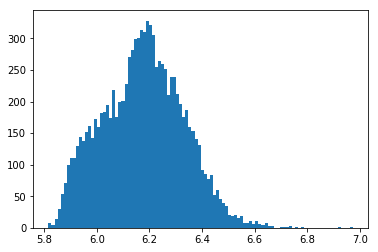

In [554]:
plt.hist(u_output.cpu().numpy(), bins=100)
u_output_mean=u_output.cpu().numpy().mean()

In [555]:
print(treat_group.mean()-untreat_group.mean())
print(treat_group.mean()-output_mean)
print(u_output_mean-untreat_group.mean())
print(((treat_group.mean()-output_mean)+(u_output_mean-untreat_group.mean()))/2)

2.3234441779164534
1.995703648354282
2.419984677816566
2.207844163085424


(array([  7.,   5.,  14.,  30.,  53.,  71.,  99., 110., 111., 130., 144.,
        138., 152., 162., 142., 172., 159., 182., 183., 194., 174., 219.,
        176., 199., 201., 228., 270., 282., 299., 300., 313., 310., 328.,
        322., 306., 254., 264., 259., 252., 211., 239., 239., 212., 196.,
        176., 186., 159., 153., 140., 131.,  92.,  86.,  78.,  84.,  52.,
         60.,  46.,  40.,  35.,  21.,  18.,  20.,  16.,  18.,   8.,   7.,
         10.,   6.,  11.,   6.,   5.,   7.,   3.,   3.,   0.,   0.,   2.,
          2.,   1.,   3.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([5.815931 , 5.827507 , 5.839083 , 5.8506594, 5.8622355, 5.8738117,
        5.8853884, 5.8969646, 5.9085407, 5.920117 , 5.931693 , 5.9432693,
        5.9548454, 5.9664216, 5.977998 , 5.9895744, 6.0011506, 6.012727 ,
        6.024303 , 6.035879 , 6.0474553, 6.0590315, 6.0706077, 6.082184 ,
        6.09376  , 6.1

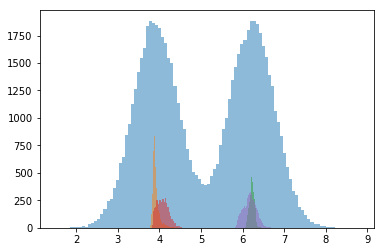

In [556]:
plt.hist(data[:,input_dim+1],bins=100,alpha=0.5)
plt.hist(untreated_outcome.cpu().detach().numpy(),bins=100,alpha=0.5)
plt.hist(treated_outcome.cpu().detach().numpy(),bins=100,alpha=0.5)
plt.hist(t_output.cpu().numpy(), bins=100,alpha=0.5)
plt.hist(u_output.cpu().numpy(), bins=100,alpha=0.5)

(array([  7.,   5.,  14.,  30.,  53.,  71.,  99., 110., 111., 130., 144.,
        138., 152., 162., 142., 172., 159., 182., 183., 194., 174., 219.,
        176., 199., 201., 228., 270., 282., 299., 300., 313., 310., 328.,
        322., 306., 254., 264., 259., 252., 211., 239., 239., 212., 196.,
        176., 186., 159., 153., 140., 131.,  92.,  86.,  78.,  84.,  52.,
         60.,  46.,  40.,  35.,  21.,  18.,  20.,  16.,  18.,   8.,   7.,
         10.,   6.,  11.,   6.,   5.,   7.,   3.,   3.,   0.,   0.,   2.,
          2.,   1.,   3.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([5.815931 , 5.827507 , 5.839083 , 5.8506594, 5.8622355, 5.8738117,
        5.8853884, 5.8969646, 5.9085407, 5.920117 , 5.931693 , 5.9432693,
        5.9548454, 5.9664216, 5.977998 , 5.9895744, 6.0011506, 6.012727 ,
        6.024303 , 6.035879 , 6.0474553, 6.0590315, 6.0706077, 6.082184 ,
        6.09376  , 6.1

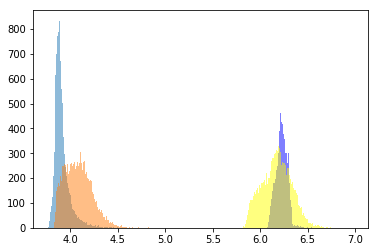

In [557]:
plt.hist(untreated_outcome.cpu().detach().numpy(),bins=100,alpha=0.5)
plt.hist(treated_outcome.cpu().detach().numpy(),bins=100,alpha=0.5,color='blue')
plt.hist(t_output.cpu().numpy(), bins=100,alpha=0.5)
plt.hist(u_output.cpu().numpy(), bins=100,alpha=0.5,color="yellow")

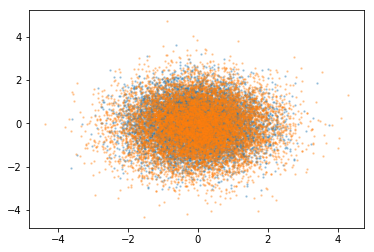

In [558]:
plt.scatter(z1.get('z').cpu().numpy()[:,0],z1.get('z').cpu().numpy()[:,1],s=2,alpha=0.3)
plt.scatter(z2.get('z').cpu().numpy()[:,0],z2.get('z').cpu().numpy()[:,1],s=2,alpha=0.3)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   3.,   2.,
          3.,   3.,   6.,   2.,   7.,  14.,  13.,  14.,  14.,  25.,  31.,
         32.,  25.,  30.,  40.,  45.,  54.,  81.,  69.,  90., 109., 117.,
        128., 130., 152., 155., 192., 199., 213., 223., 271., 240., 258.,
        266., 277., 286., 304., 327., 336., 313., 349., 360., 328., 296.,
        282., 309., 270., 241., 257., 227., 216., 211., 179., 151., 165.,
        120., 121., 103., 108.,  92.,  81.,  74.,  55.,  37.,  33.,  48.,
         34.,  35.,  21.,  21.,  13.,  14.,   5.,  12.,   1.,   7.,   3.,
          5.,   1.,   2.,   2.,   3.,   0.,   1.,   0.,   1.,   2.,   0.,
          1.]),
 array([-4.3775353 , -4.2908716 , -4.2042084 , -4.1175447 , -4.030881  ,
        -3.9442174 , -3.857554  , -3.7708902 , -3.6842268 , -3.5975633 ,
        -3.5108995 , -3.424236  , -3.3375723 , -3.2509089 , -3.1642454 ,
        -3.0775816 , -2.9909182 , -2.9042547 , -2.817591  , -2.7309275 ,
        -2.6442637 , -2.55

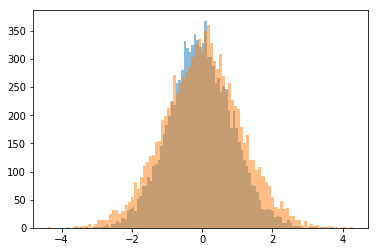

In [559]:
plt.hist(z1.get('z').cpu().numpy()[:,0], bins=100,alpha=0.5)
plt.hist(z2.get('z').cpu().numpy()[:,0], bins=100,alpha=0.5)

(array([  1.,   1.,   0.,   2.,   0.,   0.,   2.,   3.,   2.,   4.,   3.,
          6.,   3.,   9.,  13.,  10.,  15.,  17.,  15.,  26.,  30.,  44.,
         58.,  57.,  62.,  71.,  84.,  93., 109., 102., 139., 151., 164.,
        183., 199., 182., 230., 253., 280., 263., 294., 282., 336., 319.,
        320., 321., 320., 335., 298., 337., 321., 340., 314., 263., 245.,
        295., 212., 223., 205., 194., 169., 152., 162., 115., 108., 105.,
         84.,  80.,  67.,  51.,  45.,  33.,  30.,  24.,  27.,  25.,  14.,
          6.,  11.,   7.,   3.,   4.,   7.,   1.,   3.,   2.,   0.,   1.,
          0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-4.336243  , -4.2455626 , -4.154882  , -4.064202  , -3.9735212 ,
        -3.8828406 , -3.79216   , -3.7014797 , -3.610799  , -3.5201185 ,
        -3.429438  , -3.3387575 , -3.2480772 , -3.1573966 , -3.066716  ,
        -2.9760356 , -2.885355  , -2.7946744 , -2.703994  , -2.6133134 ,
        -2.522633  , -2.43

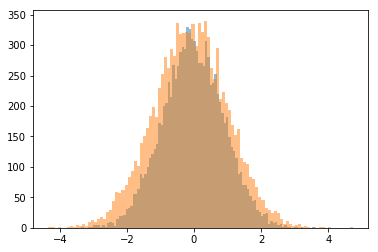

In [560]:
plt.hist(z1.get('z').cpu().numpy()[:,1], bins=100,alpha=0.5)
plt.hist(z2.get('z').cpu().numpy()[:,1], bins=100,alpha=0.5)

In [561]:
plt.hist(z1.get('z').cpu().numpy()[:,3], bins=100,alpha=0.5)
plt.hist(z2.get('z').cpu().numpy()[:,3], bins=100,alpha=0.5)

IndexError: index 3 is out of bounds for axis 1 with size 3